# XGBoost Model

The XGBoost library allows to measure and plot the feature importance of a model. This is interesting for the following reasons: Model interpretability if the features are explainable, and also feature selection, where we can select the features to keep in (and the features to drop) the input dataset to get the best results. This step and the hyperparameter tuning step can be run iteratively in order to obtain the best features and the best hyperparameter combination. The notebook and scripts make use of the following:
- `XGBClassifier` model from the xgboost library
- hyperopt library for hyperparameter tuning
- Model evaluation with cross-validation mean metrics, confusion matrices, classification reports and feature importance
- Weighted f1-score evolution with number of parameters for feature selection

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../scripts')
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings
warnings.filterwarnings('ignore')
import pickle
from IPython.display import display, HTML
from xgboost import XGBClassifier
from hyperopt import hp,STATUS_OK, tpe, Trials, fmin
import scoring_and_evaluation
import XGBoost_feature_selection
import preprocessing
import feature_preprocessing

In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
from scoring_and_evaluation import evaluate_model_with_cv
from XGBoost_feature_selection import feature_selection_with_thresholds
from preprocessing import save_list_to_pkl, load_list_from_pkl

In [10]:
list_path = '../data/lists/'
metadata_file = '../data/processed/metadata.csv'
metadata_df = pd.read_csv(metadata_file)
display(HTML(metadata_df.to_html()))

,DataFrame,Shape,Comments
0,df_input,"(33320, 127)",Complete cleaned input data
1,df_study,"(9227, 87)",Cleaned + filtered input data based on paper's specifications + deleted features missing >10% data
2,data,"(9227, 83)",df_study without target variables
3,target_cat,"(9227,)",target phq9_cat_end from df_study
4,data_train,"(8304, 83)",90% of df data for model training
5,data_test,"(923, 83)",10% of df data for model testing
6,target_train,"(8304,)",90% of df target_cat for model training
7,target_test,"(923,)",10% of df target_cat for model testing
8,X_train_full,"(8304, 143)",data_train df with all additional feature engineering columns (+50)
9,X_train_full_preprocessed,"(8304, 145)","X_train_full df with preprocessing (imputation, scaling...)"


## XGBoost model and evaluation

A first XGBoost model is fit and evaluated:

In [34]:
model_xgb = XGBClassifier(n_estimators=210,
                          max_depth=8,
                          learning_rate=0.83,
                          subsample=1.0,
                          colsample_bytree=0.95,
                          colsample_bynode=0.95,
                          colsample_bylevel=0.95,
                          max_delta_step= 0,
                          max_leaves=250,
                          min_child_weight = 1.7,
                          reg_lambda = 1.35,
                          reg_alpha = 0,
                          multi_class='multinomial',
                          use_label_encoder=False,
                          error_score='raise', 
                          n_jobs=4)

In [5]:
data_add_features_preprocessed = pd.read_pickle(r'../data/processed/data_add_features_preprocessed')

Thanks to the [evaluate_model_with_cv](https://github.com/jloayza10/depression_prediction_project/tree/main/scripts/scoring_and_evaluation.py)  custom function, a thorough evaluation of the models is performed. 

[10:03:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:03:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some

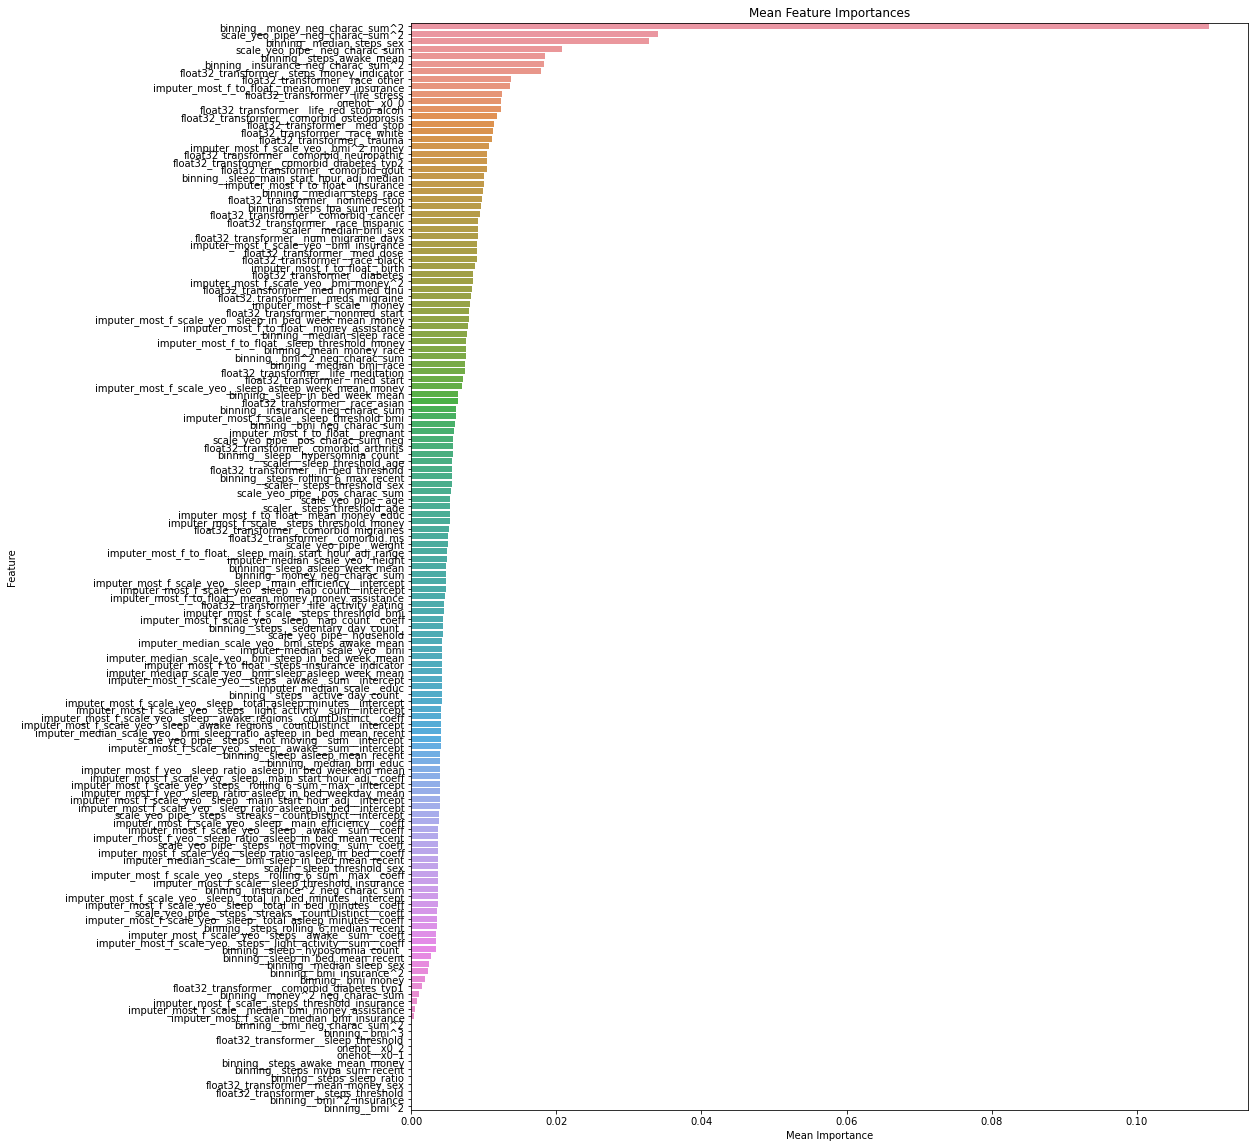

In [42]:
evaluation_df_1, confusion_matrices_1, reports_1, feature_importance_df_1 = evaluate_model_with_cv(X = data_add_features_preprocessed, y = target_cat, model = model_xgb, n_splits = 5, plot = True)

The feature importance plot shows how the interaction between the `money` feature multiplied by the `neg_charac_sum^2`, which is the count of some negative characteristics, is the most important feature for predicting the target. The 2nd most important feature is `neg_charac_sum^2` by itself, and the 3rd one is the binned median steps by sex of the individual. This is true only for this XGBoost model and the input features given to it.

In [43]:
evaluation_df_1

,Metric,Mean,Std
0,Accuracy,0.451607,0.010897
1,Cohen_s Kappa,0.431426,0.016519
2,F1 Score,0.433799,0.009793
3,Adjacent Accuracy,0.825729,0.008687


In [44]:
confusion_matrices_1

[array([[493, 160,  40,   6,   2],
        [224, 230,  70,  20,   4],
        [ 76, 138,  87,  26,  11],
        [ 28,  64,  37,  26,  14],
        [ 11,  30,  15,  22,  12]], dtype=int64),
 array([[502, 143,  47,   7,   2],
        [211, 227,  83,  22,   5],
        [ 95, 118,  91,  24,  10],
        [ 36,  47,  51,  25,   9],
        [ 14,  33,  19,  18,   7]], dtype=int64),
 array([[497, 144,  47,   9,   4],
        [205, 219,  98,  22,   4],
        [ 81, 130,  89,  29,   9],
        [ 35,  61,  42,  25,   5],
        [ 11,  25,  22,  20,  12]], dtype=int64),
 array([[497, 164,  30,   7,   2],
        [238, 205,  82,  21,   3],
        [ 76, 147,  88,  22,   5],
        [ 32,  62,  43,  22,   9],
        [ 16,  24,  20,  13,  17]], dtype=int64),
 array([[476, 162,  46,  13,   3],
        [212, 211,  91,  27,   8],
        [ 83, 144,  72,  28,  11],
        [ 29,  56,  49,  23,  11],
        [ 17,  17,  26,  16,  14]], dtype=int64)]

In [45]:
reports_1

[{'0.0': {'precision': 0.5925480769230769,
   'recall': 0.703281027104137,
   'f1-score': 0.6431833007175473,
   'support': 701},
  '1.0': {'precision': 0.36977491961414793,
   'recall': 0.4197080291970803,
   'f1-score': 0.39316239316239315,
   'support': 548},
  '2.0': {'precision': 0.3493975903614458,
   'recall': 0.257396449704142,
   'f1-score': 0.29642248722316866,
   'support': 338},
  '3.0': {'precision': 0.26,
   'recall': 0.15384615384615385,
   'f1-score': 0.1933085501858736,
   'support': 169},
  '4.0': {'precision': 0.27906976744186046,
   'recall': 0.13333333333333333,
   'f1-score': 0.18045112781954886,
   'support': 90},
  'accuracy': 0.4593716143011918,
  'macro avg': {'precision': 0.37015807086810626,
   'recall': 0.33351299863696926,
   'f1-score': 0.3413055718217063,
   'support': 1846},
  'weighted avg': {'precision': 0.43616767198459705,
   'recall': 0.4593716143011918,
   'f1-score': 0.44172536967637877,
   'support': 1846}},
 {'0.0': {'precision': 0.585081585081

### Feature selection

A recursive feature selection is performed, thanks to the following methodology: Given that the feature importance for each feature is known, we train the model by adding one feature at a time (from most important to least) and compute the weighted f1-score. The results allow to get the optimum number of features to select to get the best score.
Then, it is possible to perform a hyperparameter tuning with only these selected features. With the new values of hyperparameters, it is possible to recursively rerun this methodology.

In [46]:
feature_importance_df_1

,Importance
Feature,
binning__money_neg_charac_sum^2,0.109932
scale_yeo_pipe__neg_charac_sum^2,0.034004
binning__median_steps_sex,0.032799
scale_yeo_pipe__neg_charac_sum,0.020702
binning__steps_awake_mean,0.018486
...,...
binning__steps_sleep_ratio,0.000000
float32_transformer__mean_money_sex,0.000000
float32_transformer__steps_threshold,0.000000


In [47]:
selected_features = feature_importance_df_1.index[:80].tolist()

In [8]:
X_train_full_preprocessed = pd.read_pickle(r'../data/processed/X_train_full_preprocessed')
X_test_full_preprocessed = pd.read_pickle(r'../data/processed/X_test_full_preprocessed')
target_train = pd.read_pickle(r'../data/processed/target_train')
target_test = pd.read_pickle(r'../data/processed/target_test')
target_cat = pd.read_pickle(r'../data/processed/target_cat')

[10:48:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:48:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:48:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some

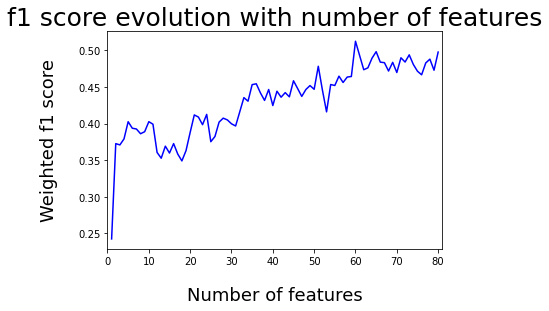

In [60]:
feature_list_1, thresholds_df_1, feat_selection_plot = feature_selection_with_thresholds(xgb_model_fs = model_xgb,
                                                                                         df_train = X_train_full_preprocessed[selected_features],
                                                                                         df_test = X_test_full_preprocessed[selected_features], 
                                                                                         target_for_train = target_train,
                                                                                         target_for_test = target_test)

In [61]:
feature_list_1

,Threshold,Number of features,f1 score
0,0.002446,80,0.497510
1,0.003341,79,0.472744
2,0.005707,78,0.487852
3,0.005759,77,0.482670
4,0.005945,76,0.466513
...,...,...,...
75,0.022525,5,0.402515
76,0.022568,4,0.379080
77,0.023255,3,0.370836
78,0.028156,2,0.372600


In [62]:
thresholds_df_1

,0
scaler__median_bmi_sex,0.002446
binning__sleep__hypersomnia_count_,0.003341
onehot__x0_0,0.005707
imputer_most_f_to_float__sleep_main_start_hour_adj_range,0.005759
binning__insurance_neg_charac_sum,0.005945
...,...
binning__median_bmi_race,0.022525
binning__bmi^2_neg_charac_sum,0.022568
binning__money_neg_charac_sum^2,0.023255
scale_yeo_pipe__neg_charac_sum^2,0.028156


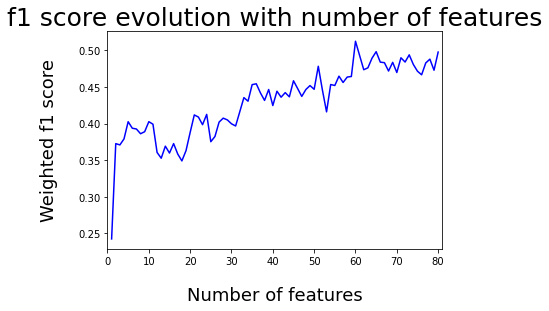

In [67]:
feat_selection_plot.figure

In [68]:
feature_list_1[feature_list_1['f1 score']>0.5]

,Threshold,Number of features,f1 score
20,0.007631,60,0.512286


In [81]:
selected_features_1 = thresholds_df_1[thresholds_df_1.values>0.007631].index.tolist()
save_list_to_pkl(selected_features_1, '../data/lists/','selected_features_1')

In [11]:
selected_features_1 = load_list_from_pkl(list_path+'selected_features_1.pkl')

The selected features are saved and loaded in pickle format.

## Hyperparameter Tuning

The hyperpameter tuning process is performed with the previously presented `evaluate_model_with_cv`, so the weighted f1-score obtained on each of the runs for the selected hyperparameter values is obtained after 5 runs (with 5 splits) of the cross-validation, instead of doing it with only 1 train set and 1 test set.

In [ ]:
def objective_function_with_cv(params):
    space, selected_features = params
    
    model_xgb = XGBClassifier(learning_rate = space['learning_rate'],
                              n_estimators = int(space['n_estimators']),
                              max_depth = int(space['max_depth']),
                              min_child_weight = space['min_child_weight'],
                              max_delta_step = int(space['max_delta_step']),
                              subsample = space['subsample'],
                              colsample_bytree = space['colsample_bytree'],
                              colsample_bylevel = space['colsample_bylevel'],
                              colsample_bynode = space['colsample_bynode'],
                              max_leaves = int(space['max_leaves']),
                              reg_alpha = space['reg_alpha'],
                              reg_lambda = space['reg_lambda'],
                              verbosity=0,
                              multi_class='multinomial',use_label_encoder=False,error_score='raise', n_jobs=4)
    
    results = evaluate_model_with_cv(data_add_features_preprocessed[list(selected_features)], target_cat, model_xgb, 5)
    score = results[0].loc[results[0]['Metric']=='Accuracy']['Mean'].values[0]
    f1 = results[0].loc[results[0]['Metric']=='F1 Score']['Mean'].values[0]
    cohen_kappa = results[0].loc[results[0]['Metric']=='Cohen_s Kappa']['Mean'].values[0]
    adjacent_accuracy = results[0].loc[results[0]['Metric']=='Adjacent Accuracy']['Mean'].values[0]
    
    print (f"balanced accuracy: {score}, f1 weighted = {f1}, Kappa = {cohen_kappa}, Adj. Acc. = {adjacent_accuracy}")
    return {'loss': -f1,
            'balanced_acc': -score,
            'status': STATUS_OK,
            'features': selected_features}

In [229]:
space_xgb_1 = {'learning_rate': hp.quniform('learning_rate', 0.01, 0.9, 0.05),
               'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
               'max_depth': hp.choice('max_depth', [3,4,5,6,7,8]),
               'min_child_weight': hp.quniform('min_child_weight', 1, 2, 0.1),
               'subsample': hp.quniform('subsample', 0.90, 1, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.92, 1, 0.05),
               'colsample_bylevel': hp.quniform('colsample_bylevel', 0.92, 1, 0.05),
               'colsample_bynode': hp.quniform('colsample_bynode', 0.88, 1, 0.05),
               'max_delta_step': hp.quniform('max_delta_step', 0.5, 1, 0.05),
               'max_leaves': hp.quniform('max_leaves', 100, 500, 50),
               'reg_lambda': hp.quniform('reg_lambda', 1.0, 1.6, 0.05)
              }

In [231]:
trials = Trials()

In [232]:
best_params_1 = fmin(objective_function_with_cv,
                    space=(space_xgb_1,selected_features_1),
                    algo=tpe.suggest, 
                    max_evals=150,
                    trials=trials
                   )

[19:07:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576:                                        
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:07:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:08:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576:                                        
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by lang

In [233]:
best_params_1 #balanced accuracy: 0.5202117520633495, f1 weighted = 0.5157696377935592, Kappa = 0.6027224440816388, Adj. Acc. = 0.8767749796674564

{'colsample_bylevel': 1.0,
 'colsample_bynode': 0.9500000000000001,
 'colsample_bytree': 1.0,
 'learning_rate': 0.8300000000000001,
 'max_delta_step': 0.7000000000000001,
 'max_depth': 5,
 'max_leaves': 170.0,
 'min_child_weight': 1.0,
 'n_estimators': 200.0,
 'reg_lambda': 1.25,
 'subsample': 1.0}

In [234]:
space_xgb_2 = {'learning_rate': hp.quniform('learning_rate', 0.01, 0.9, 0.05),
               'n_estimators': hp.quniform('n_estimators', 100, 500, 25),
               'max_depth': hp.choice('max_depth', [4.0,5.0,6.0]),
               'min_child_weight': hp.quniform('min_child_weight', 0.8, 1.02, 0.05),
               'subsample': hp.quniform('subsample', 0.95, 1, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.95, 1, 0.01),
               'colsample_bylevel': hp.quniform('colsample_bylevel', 0.95, 1, 0.01),
               'colsample_bynode': hp.quniform('colsample_bynode', 0.95, 1, 0.01),
               'max_delta_step': hp.quniform('max_delta_step', 0.6, 0.8, 0.0025),
               'max_leaves': hp.quniform('max_leaves', 150, 250, 10),
               'reg_lambda': hp.quniform('reg_lambda', 1.2, 1.4, 0.05)
              }

In [235]:
trials = Trials()
best_params_2 = fmin(objective_function_with_cv,
                    space=(space_xgb_2,selected_features_1),
                    algo=tpe.suggest, 
                    max_evals=150,
                    trials=trials
                   )

[21:35:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576:                                        
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:35:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576:                                        
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by lang

In [237]:
best_params_2 #balanced accuracy: 0.5233559119989899, f1 weighted = 0.5179595390821927, Kappa = 0.6122364035159211, Adj. Acc. = 0.8807855261651207

{'colsample_bylevel': 0.99,
 'colsample_bynode': 0.99,
 'colsample_bytree': 0.99,
 'learning_rate': 0.35000000000000003,
 'max_delta_step': 0.655,
 'max_depth': 2,
 'max_leaves': 220.0,
 'min_child_weight': 0.9,
 'n_estimators': 425.0,
 'reg_lambda': 1.25,
 'subsample': 0.9500000000000001}

In [14]:
space_xgb_3 = {'learning_rate': hp.loguniform('learning_rate', -3, 0),
               'n_estimators': hp.quniform('n_estimators', 400, 500, 10),
               'max_depth': hp.choice('max_depth', np.arange(8, 50, 1, dtype=int)),
               'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
               'subsample': hp.quniform('subsample', 0.90, 0.96, 0.001),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.95, 1, 0.01),
               'colsample_bylevel': hp.quniform('colsample_bylevel', 0.95, 1, 0.01),
               'colsample_bynode': hp.quniform('colsample_bynode', 0.95, 1, 0.01),
               'max_delta_step': hp.quniform('max_delta_step', 0.64, 0.7, 0.0025),
               'max_leaves': hp.quniform('max_leaves', 200, 250, 5),
               'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
               'reg_lambda': hp.loguniform('reg_lambda', -5, -1)
              }

In [17]:
trials = Trials()
best_params_3 = fmin(objective_function_with_cv,
                    space=(space_xgb_3,selected_features_1),
                    algo=tpe.suggest, 
                    max_evals=30,
                    trials=trials
                   )

[08:47:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576:                                        
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:47:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:47:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576:                                        
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by lang

In [18]:
best_params_3 #balanced accuracy: 0.5234635496950852, f1 weighted = 0.5192701568337916, Kappa = 0.6136131240497988, Adj. Acc. = 0.8830614791521697

{'colsample_bylevel': 0.99,
 'colsample_bynode': 0.97,
 'colsample_bytree': 0.98,
 'learning_rate': 0.12219014942896811,
 'max_delta_step': 0.6725,
 'max_depth': 17,
 'max_leaves': 235.0,
 'min_child_weight': 0.5312590964947956,
 'n_estimators': 500.0,
 'reg_alpha': 0.03352760516064557,
 'reg_lambda': 0.02047128764077248,
 'subsample': 0.9450000000000001}

In [19]:
model_xgb_2 = XGBClassifier(n_estimators=500,
                            max_depth=17,
                            learning_rate=0.12219014942896811,
                            subsample=0.945,
                            colsample_bytree=0.98,
                            colsample_bynode=0.97,
                            colsample_bylevel=0.99,
                            max_delta_step= 0.6725,
                            max_leaves=235,
                            min_child_weight = 0.5312590964947956,
                            reg_lambda = 0.02047128764077248,
                            reg_alpha = 0.03352760516064557,
                            multi_class='multinomial',
                            use_label_encoder=False,
                            error_score='raise', 
                            n_jobs=4)

[11:35:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:35:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score", "multi_class" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some

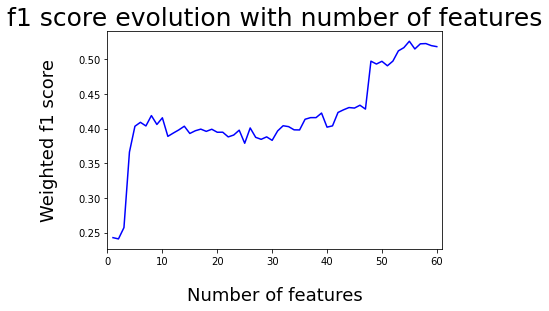

In [20]:
feature_list_2, thresholds_df_2, feat_selection_plot_2 = feature_selection_with_thresholds(xgb_model_fs = model_xgb_2,
                                                                                           df_train = X_train_full_preprocessed[selected_features_1],
                                                                                           df_test = X_test_full_preprocessed[selected_features_1], 
                                                                                           target_for_train = target_train,
                                                                                           target_for_test = target_test)

In [21]:
feature_list_2[feature_list_2['f1 score']>0.5]

,Threshold,Number of features,f1 score
0,0.009323,60,0.518352
1,0.011364,59,0.519815
2,0.011485,58,0.522781
3,0.012074,57,0.522407
4,0.012301,56,0.515010
5,0.012418,55,0.526138
6,0.012469,54,0.516904
7,0.012758,53,0.512239


In [22]:
selected_features_2 = thresholds_df_2[thresholds_df_2.values>0.011485].index.tolist()
#save_list_to_pkl(selected_features_2, '../data/lists/','selected_features_2')

In [6]:
selected_features_2 = load_list_from_pkl('../data/lists/selected_features_2.pkl')

In [7]:
len(selected_features_2)

57

In [ ]:
{'colsample_bylevel': 0.972,
 'colsample_bynode': 0.984,
 'colsample_bytree': 0.967,
 'learning_rate': 0.122663990115494,
 'max_delta_step': 0.6825,
 'max_depth': 11,
 'max_leaves': 234.0,
 'min_child_weight': 0.41260085649567163,
 'min_split_loss': 100.0,
 'n_estimators': 486.0,
 'reg_alpha': 0.01828687399622085,
 'reg_lambda': 0.06289243410776137,
 'subsample': 0.9550000000000001}

In [35]:
space_xgb_4 = {'colsample_bylevel': hp.quniform('colsample_bylevel', 0.970, 0.974, 0.0005),
               'colsample_bynode': hp.quniform('colsample_bynode', 0.983, 0.985, 0.0005),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.966, 0.968, 0.0005),
               'learning_rate': hp.loguniform('learning_rate', -2.2, -1.5),
               'max_delta_step': hp.quniform('max_delta_step', 0.677, 0.686, 0.0025),
               'max_depth': hp.choice('max_depth', np.arange(10, 17, 1, dtype=int)),
               'max_leaves': hp.quniform('max_leaves', 230, 238, 1),
               'min_child_weight': hp.loguniform('min_child_weight', -0.91, -0.7),
               #'min_split_loss': hp.quniform('min_split_loss', 90, 110, 2),
               'n_estimators': hp.quniform('n_estimators', 482, 489, 1),
               'reg_alpha': hp.loguniform('reg_alpha', -4.2, -3.7),
               'reg_lambda': hp.loguniform('reg_lambda', -3.22, -2.73),
               'subsample': hp.quniform('subsample', 0.95, 0.96, 0.0001)
              }

In [36]:
trials = Trials()
best_params_4 = fmin(objective_function_with_cv,
                    space=(space_xgb_4,selected_features_2),
                    algo=tpe.suggest, 
                    max_evals=20,
                    return_argmin=False,
                    trials=trials
                   )

balanced accuracy: 0.522270961604524, f1 weighted = 0.5179901233483691, Kappa = 0.6108897300689925, Adj. Acc. = 0.8834947311553287
balanced accuracy: 0.5231378179437266, f1 weighted = 0.5189759096830862, Kappa = 0.6143545470934172, Adj. Acc. = 0.8830611268192856
balanced accuracy: 0.5222708441602293, f1 weighted = 0.5182627502174392, Kappa = 0.6135379185987259, Adj. Acc. = 0.8841450202150993
balanced accuracy: 0.5224873527175141, f1 weighted = 0.517735490979619, Kappa = 0.6102881768174199, Adj. Acc. = 0.8823027302862411
balanced accuracy: 0.5178281026580581, f1 weighted = 0.5139616698790237, Kappa = 0.60662583900532, Adj. Acc. = 0.8812190130568694
balanced accuracy: 0.5220546292136812, f1 weighted = 0.5172918870987535, Kappa = 0.6102321890371228, Adj. Acc. = 0.8831697627918859
balanced accuracy: 0.520862745788888, f1 weighted = 0.5166976270215577, Kappa = 0.6112835997773499, Adj. Acc. = 0.8841449614929517
balanced accuracy: 0.5197782064494535, f1 weighted = 0.5155076816589528, Kappa = 

In [38]:
best_params_4[0] #balanced accuracy: 0.5254157674837854, f1 weighted = 0.5215019606668132, Kappa = 0.6174568875086179, Adj. Acc. = 0.885121158470523

{'colsample_bylevel': 0.9725,
 'colsample_bynode': 0.9845,
 'colsample_bytree': 0.967,
 'learning_rate': 0.19126026956078931,
 'max_delta_step': 0.68,
 'max_depth': 15,
 'max_leaves': 231.0,
 'min_child_weight': 0.40374195632329707,
 'min_split_loss': 108.0,
 'n_estimators': 484.0,
 'reg_alpha': 0.02224737866704274,
 'reg_lambda': 0.05593919971672738,
 'subsample': 0.9511000000000001}

## Train and save final model

## Save preprocessor

In [17]:
data_add_features = pd.read_pickle(r'../data/processed/data_add_features')

In [29]:
data_add_features_preprocessed[selected_features_2]

,scaler__steps_threshold_age,scale_yeo_pipe__neg_charac_sum,imputer_median_scale_yeo__height,float32_transformer__comorbid_arthritis,imputer_most_f_to_float__mean_money_educ,scale_yeo_pipe__pos_charac_sum_neg,scaler__steps_threshold_sex,float32_transformer__comorbid_diabetes_typ2,imputer_most_f_to_float__sleep_threshold_money,scale_yeo_pipe__age,...,float32_transformer__life_meditation,imputer_most_f_scale_yeo__bmi_money^2,float32_transformer__life_red_stop_alcoh,float32_transformer__nonmed_stop,float32_transformer__med_dose,scale_yeo_pipe__neg_charac_sum^2,imputer_most_f_scale__money,float32_transformer__med_stop,binning__money_neg_charac_sum^2,binning__money_neg_charac_sum
0,-0.977958,-0.362444,-1.631913,0.0,0.326200,-0.148538,-0.289237,0.0,0.0,1.091399,...,0.0,-0.770257,0.0,0.0,0.0,-0.948085,-0.670020,0.0,0.0,0.0
1,-0.977958,-0.362444,-0.351441,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,-0.748699,...,0.0,-0.770257,0.0,0.0,0.0,-0.359380,-0.670020,0.0,0.0,0.0
2,-0.977958,-0.362444,-0.351441,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,-0.748699,...,0.0,-0.770257,0.0,0.0,0.0,-0.359380,-0.670020,0.0,0.0,0.0
3,1.457658,0.084279,-0.064520,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,1.020126,...,0.0,-0.770257,1.0,0.0,0.0,-0.359380,-0.670020,0.0,0.0,0.0
4,-0.977958,0.084279,-0.351441,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,-0.748699,...,0.0,-0.770257,0.0,0.0,0.0,0.056091,-0.670020,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9222,0.045001,0.084279,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.775090,0.466846,0.0,0.0,0.0
9223,0.045001,-0.362444,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.948085,0.466846,0.0,0.0,0.0
9224,0.045001,-0.362444,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.948085,0.466846,0.0,0.0,0.0
9225,0.045001,-0.362444,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.948085,0.466846,0.0,0.0,0.0


In [23]:
final_preprocessor = feature_preprocessing.get_preprocessor(data_add_features)
final_preprocessor.fit(data_add_features)

ColumnTransformer(transformers=[('imputer_most_f_to_float',
                                 Pipeline(steps=[('imputer_most_f',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('to_float32',
                                                  FunctionTransformer(func=<function to_float32 at 0x00000173D366F8B0>))]),
                                 ['sleep_main_start_hour_adj_range', 'pregnant',
                                  'birth', 'insurance', 'money_assistance',
                                  'sleep_threshold_money',
                                  'steps_insurance_indica...
                                  'life_stress', 'life_activity_eating',
                                  'comorbid_gout', 'mean_money_sex',
                                  'race_hispanic', 'in_bed_threshold',
                                  'comorbid_ms', 'med_nonmed_dnu', 'diabetes',
                       

In [24]:
with open('../models/final_preprocessor.bin','wb') as f_out:
    pickle.dump(final_preprocessor, f_out)

## Save model

In [51]:
final_model = XGBClassifier(colsample_bylevel=0.9725,
                            colsample_bynode=0.9845,
                            colsample_bytree=0.967,
                            learning_rate=0.19126026956078931,
                            max_delta_step=0.68,
                            max_depth=15,
                            max_leaves=231,
                            min_child_weight=0.40374195632329707,
                            #min_split_loss=108.0,
                            n_estimators=484,
                            reg_alpha=0.02224737866704274,
                            reg_lambda=0.05593919971672738,    
                            subsample=0.945,
                            multi_class='multinomial',
                            use_label_encoder=False,
                            error_score='raise',
                            verbosity=0,
                            n_jobs=4)

In [ ]:
learning_rate = space['learning_rate'],
n_estimators = int(space['n_estimators']),
max_depth = int(space['max_depth']),
min_child_weight = space['min_child_weight'],
max_delta_step = int(space['max_delta_step']),
subsample = space['subsample'],
colsample_bytree = space['colsample_bytree'],
colsample_bylevel = space['colsample_bylevel'],
colsample_bynode = space['colsample_bynode'],
max_leaves = int(space['max_leaves']),
reg_alpha = space['reg_alpha'],
reg_lambda = space['reg_lambda'],
verbosity=0,
multi_class='multinomial',use_label_encoder=False,error_score='raise', n_jobs=4)

In [ ]:
# XGBClassifier(
#colsample_bytree=0.95,
#colsample_bynode=0.95,
#colsample_bylevel=0.95,
#learning_rate=0.83,
#max_delta_step= 0,
#max_depth=8,
#max_leaves=250,
#min_child_weight = 1.7,
#min_split_loss NA
#n_estimators=210,
#reg_alpha = 0,
#reg_lambda = 1.35,
#subsample=1.0,
#multi_class='multinomial',
#use_label_encoder=False,
#error_score='raise', 
#n_jobs=4)

In [42]:
final_model.fit(data_add_features_preprocessed[selected_features_2], target_cat)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9725,
              colsample_bynode=0.9845, colsample_bytree=0.967,
              enable_categorical=False, error_score='raise', gamma=108,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.19126026956078931, max_delta_step=0.68,
              max_depth=15, max_leaves=231,
              min_child_weight=0.40374195632329707, min_split_loss=108.0,
              missing=nan, monotone_constraints='()', multi_class='multinomial',
              n_estimators=484, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0.02224737866704274, reg_lambda=0.05593919971672738,
              scale_pos_weight=None, subsample=0.945, ...)

In [46]:
# with open('../models/xgboost_mod.bin','wb') as f_out:
#     pickle.dump(final_model, f_out)

In [9]:
with open('../models/xgboost_mod.bin', 'rb') as f_in:
    final_model_xgb = pickle.load(f_in)

## Final tuned model evaluation with simple cross-validation

In [23]:
data_add_features_preprocessed[selected_features_2]

,scaler__steps_threshold_age,scale_yeo_pipe__neg_charac_sum,imputer_median_scale_yeo__height,float32_transformer__comorbid_arthritis,imputer_most_f_to_float__mean_money_educ,scale_yeo_pipe__pos_charac_sum_neg,scaler__steps_threshold_sex,float32_transformer__comorbid_diabetes_typ2,imputer_most_f_to_float__sleep_threshold_money,scale_yeo_pipe__age,...,float32_transformer__life_meditation,imputer_most_f_scale_yeo__bmi_money^2,float32_transformer__life_red_stop_alcoh,float32_transformer__nonmed_stop,float32_transformer__med_dose,scale_yeo_pipe__neg_charac_sum^2,imputer_most_f_scale__money,float32_transformer__med_stop,binning__money_neg_charac_sum^2,binning__money_neg_charac_sum
0,-0.977958,-0.362444,-1.631913,0.0,0.326200,-0.148538,-0.289237,0.0,0.0,1.091399,...,0.0,-0.770257,0.0,0.0,0.0,-0.948085,-0.670020,0.0,0.0,0.0
1,-0.977958,-0.362444,-0.351441,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,-0.748699,...,0.0,-0.770257,0.0,0.0,0.0,-0.359380,-0.670020,0.0,0.0,0.0
2,-0.977958,-0.362444,-0.351441,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,-0.748699,...,0.0,-0.770257,0.0,0.0,0.0,-0.359380,-0.670020,0.0,0.0,0.0
3,1.457658,0.084279,-0.064520,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,1.020126,...,0.0,-0.770257,1.0,0.0,0.0,-0.359380,-0.670020,0.0,0.0,0.0
4,-0.977958,0.084279,-0.351441,0.0,0.326200,-1.716960,-0.289237,0.0,0.0,-0.748699,...,0.0,-0.770257,0.0,0.0,0.0,0.056091,-0.670020,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9222,0.045001,0.084279,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.775090,0.466846,0.0,0.0,0.0
9223,0.045001,-0.362444,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.948085,0.466846,0.0,0.0,0.0
9224,0.045001,-0.362444,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.948085,0.466846,0.0,0.0,0.0
9225,0.045001,-0.362444,0.205245,0.0,0.535913,0.591308,-0.289237,0.0,1.0,-2.104173,...,0.0,-0.196813,0.0,0.0,0.0,-0.948085,0.466846,0.0,0.0,0.0


In [33]:
data_add_features_preprocessed[selected_features_2]['float32_transformer__life_red_stop_alcoh'].describe()

count    9227.000000
mean        0.042701
std         0.202193
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: float32_transformer__life_red_stop_alcoh, dtype: float64

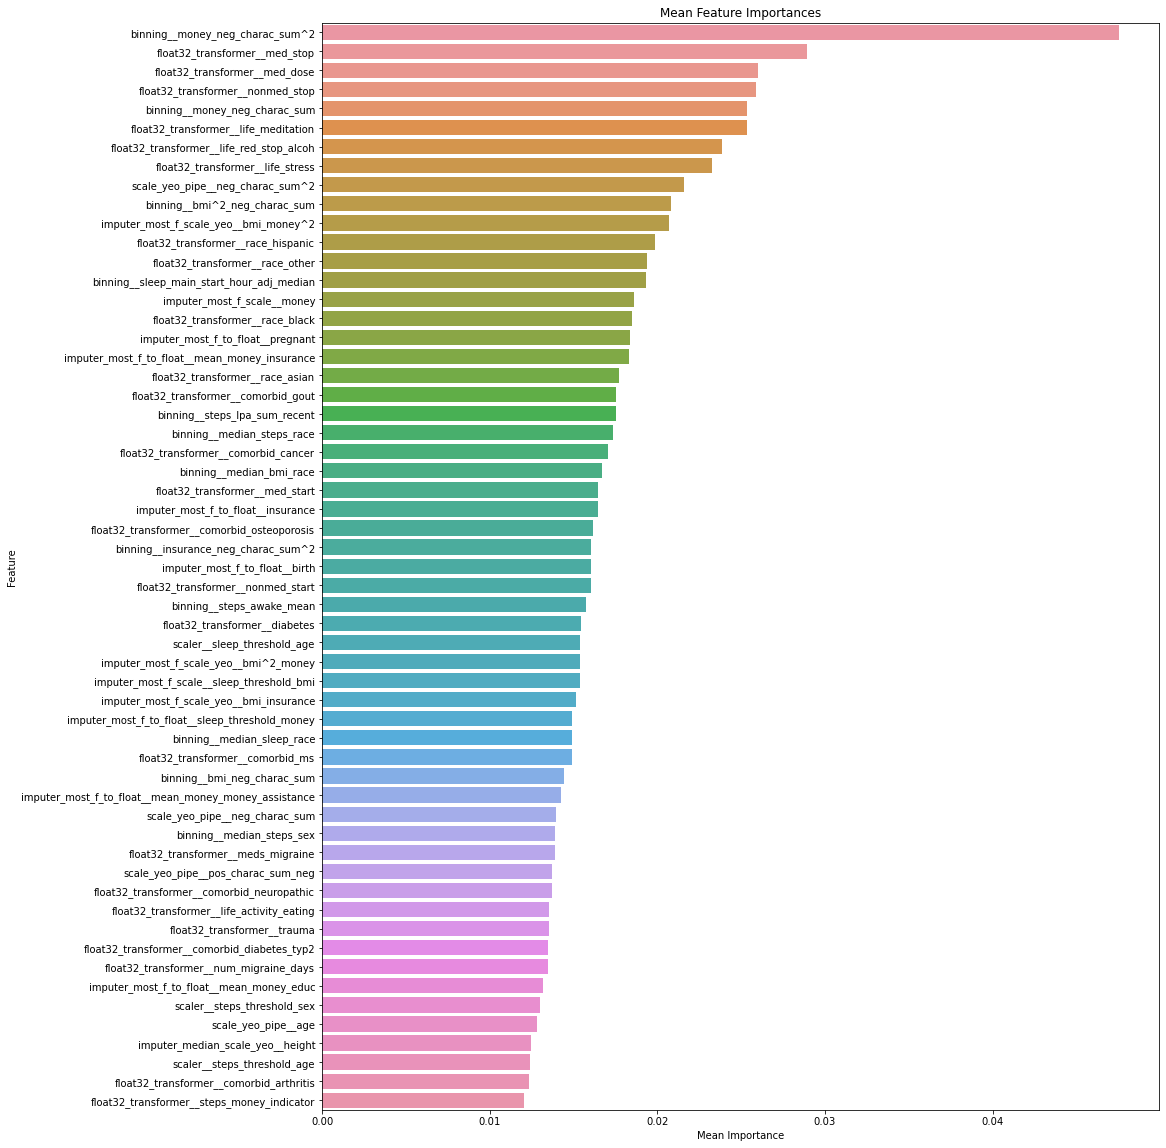

In [52]:
evaluation_final, confusion_matrices_final, reports_final, feature_importance_final = evaluate_model_with_cv(X = data_add_features_preprocessed[selected_features_2], y = target_cat, model = final_model, n_splits = 5, plot = True)

In [54]:
evaluation_final

,Metric,Mean,Std
0,Accuracy,0.521297,0.008176
1,Cohen_s Kappa,0.611620,0.011253
2,F1 Score,0.516961,0.007133
3,Adjacent Accuracy,0.883279,0.005397


In [55]:
confusion_matrices_final

[array([[481, 170,  43,   5,   2],
        [171, 262,  80,  30,   5],
        [ 31, 116, 124,  55,  12],
        [ 11,  44,  42,  42,  30],
        [ 10,  11,  25,  16,  28]], dtype=int64),
 array([[531, 135,  28,   7,   0],
        [152, 275,  90,  24,   7],
        [ 40, 127, 112,  49,  10],
        [ 15,  44,  44,  41,  24],
        [  8,  18,  23,  22,  20]], dtype=int64),
 array([[512, 152,  25,   7,   5],
        [156, 243, 120,  20,   9],
        [ 56, 117, 118,  35,  12],
        [ 12,  38,  56,  47,  15],
        [  3,  15,  11,  23,  38]], dtype=int64),
 array([[509, 147,  37,   6,   1],
        [158, 260, 102,  25,   4],
        [ 37, 137, 120,  35,   9],
        [ 11,  35,  52,  52,  18],
        [  8,  10,  18,  19,  35]], dtype=int64),
 array([[510, 153,  24,   9,   4],
        [150, 268, 100,  21,  10],
        [ 45, 123, 114,  44,  12],
        [ 15,  35,  54,  42,  22],
        [  7,  14,  14,  29,  26]], dtype=int64)]

In [70]:
reports_final

[{'0.0': {'precision': 0.6832386363636364,
   'recall': 0.6861626248216833,
   'f1-score': 0.6846975088967971,
   'support': 701},
  '1.0': {'precision': 0.43449419568822556,
   'recall': 0.4781021897810219,
   'f1-score': 0.45525629887054736,
   'support': 548},
  '2.0': {'precision': 0.39490445859872614,
   'recall': 0.3668639053254438,
   'f1-score': 0.38036809815950917,
   'support': 338},
  '3.0': {'precision': 0.28378378378378377,
   'recall': 0.2485207100591716,
   'f1-score': 0.26498422712933756,
   'support': 169},
  '4.0': {'precision': 0.36363636363636365,
   'recall': 0.3111111111111111,
   'f1-score': 0.3353293413173653,
   'support': 90},
  'accuracy': 0.5075839653304443,
  'macro avg': {'precision': 0.4320114876141471,
   'recall': 0.4181521082196863,
   'f1-score': 0.4241270948747113,
   'support': 1846},
  'weighted avg': {'precision': 0.5044515398272796,
   'recall': 0.5075839653304443,
   'f1-score': 0.5054061743223455,
   'support': 1846}},
 {'0.0': {'precision': 0.

Example of a report classification for one of the 5 splits for each of the 5 categories to be predicted:

In [72]:
pd.DataFrame(reports_final[2]).T

,precision,recall,f1-score,support
0.0,0.692828,0.730385,0.711111,701.000000
1.0,0.430088,0.443431,0.436658,548.000000
2.0,0.357576,0.349112,0.353293,338.000000
3.0,0.356061,0.279762,0.313333,168.000000
4.0,0.481013,0.422222,0.449704,90.000000
accuracy,0.519241,0.519241,0.519241,0.519241
macro avg,0.463513,0.444982,0.452820,1845.000000
weighted avg,0.512375,0.519241,0.515070,1845.000000


In [57]:
feature_importance_final

,Importance
Feature,
binning__money_neg_charac_sum^2,0.047563
float32_transformer__med_stop,0.028924
float32_transformer__med_dose,0.025980
float32_transformer__nonmed_stop,0.025892
binning__money_neg_charac_sum,0.025363
float32_transformer__life_meditation,0.025359
float32_transformer__life_red_stop_alcoh,0.023874
float32_transformer__life_stress,0.023241
scale_yeo_pipe__neg_charac_sum^2,0.021590


In [58]:
confusion_matrices_final[2]

array([[512, 152,  25,   7,   5],
       [156, 243, 120,  20,   9],
       [ 56, 117, 118,  35,  12],
       [ 12,  38,  56,  47,  15],
       [  3,  15,  11,  23,  38]], dtype=int64)

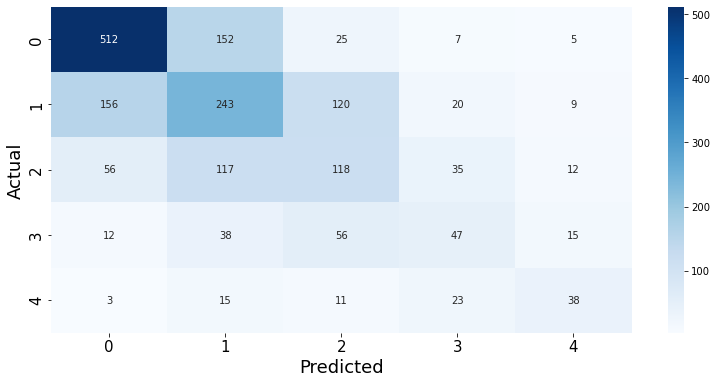

In [69]:
plt.figure(figsize=(13,6))
sns.heatmap(confusion_matrices_final[2], annot=True, xticklabels=["0", "1", "2","3","4"], yticklabels=["0", "1", "2","3","4"], cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize=18)
plt.xticks(size=15)
plt.ylabel('Actual', fontsize=18)
plt.yticks(size=15)
plt.title('')
plt.show()